In [1]:
import pandas as pd
import pickle
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import f1_score
from scipy.stats import entropy

In [2]:
from scipy.fft import rfft, rfftfreq, irfft

In [3]:
# Const
RANDOM_STATE = 0

# Полезные методы

In [4]:
def make_XY(df):
    """
    Подготовка признаков для обучения модели
    df: dataset
    return:
    X: numpy array with features, values are scaled
    y: numpy array of target labels
    """
    X = df.drop(['y','id','time'], axis=1)
    y = df.y.to_numpy()

    scaler = StandardScaler().fit(X.to_numpy())
    X = scaler.transform(X.to_numpy())

    with open('scaler-isd-pipeline-10.pkl', 'wb') as f:
        pickle.dump(scaler, f)
        
    print('scaler-isd-pipeline-10.pkl was saved in output directory')

    return X, y


def get_train_test_indexes(X,y):
    """
    X,y: numpy arrays with features and target
    return stratified indexes:
        train_indexes: indexes for train data
        test_indexes: indexes for test data
    """
    skf = StratifiedKFold()
    folds = dict()
    for i, (train_indexes, test_indexes) in enumerate(skf.split(X,y)):
        folds[i] = {
            'train_indexes': train_indexes,
            'test_indexes': test_indexes
        }
    return folds[0]['train_indexes'].tolist(), folds[0]['test_indexes'].tolist()


def plot_RR(rr_ids, data):
    """
    Рисует графики ритмограмм с разметкой аномальных участков
    rr_ids: список идентификаторов ритмограмм
    data: набор данных
    """
    df = data.set_index('time').copy()
    for rr_id in rr_ids:
        fig = plt.figure(figsize=(20,5))
        plt.title(f'R-R №{rr_id}')
        plt.plot(df[df.id == rr_id].x, '-o', zorder=1)
        df_anomaly = df[(df.id == rr_id)&(df.y == 1)].reset_index()
        df_anomaly['time-diff'] = df_anomaly.time.diff()
        split_indexes = df_anomaly[df_anomaly['time-diff'] > 1000].index
        split_indexes = list(split_indexes)
        split_indexes.append(0)
        split_indexes.sort()
        len_spl = len(split_indexes)
        for i in range(len_spl):
            if i == len_spl-1:
                mask = (df_anomaly.index >= split_indexes[i])
                plt.plot(df_anomaly[mask].time, df_anomaly[mask].x, '-o',
                     label='аномальный участок', color='red', zorder=2)
            else:
                mask = (df_anomaly.index >= split_indexes[i])&(df_anomaly.index < split_indexes[i+1])
                plt.plot(df_anomaly[mask].time, df_anomaly[mask].x, '-o',
                         color='red', zorder=2)
        plt.legend()
        plt.xlabel('R-R timeline, ms')
        plt.ylabel('R-R interval')
        plt.show()
        
        
def entropy1(labels, base=None):
    _, counts = np.unique(labels, return_counts=True)
    return entropy(counts, base=base)


def make_dataset(data):
    """
    Автоматизация подготовки датасета
    """
    df = data.copy()
    ids = df.id.unique()
    for rr_id in ids:
        mask = (df.id==rr_id) 
        
        DURATION = df.loc[mask].time.index[-1]-df.loc[mask].time.index[0]
        SAMPLE_RATE = len(df.loc[mask])/DURATION
        N = int(SAMPLE_RATE * DURATION)
        yf = rfft(df.loc[mask, 'x'])
        for j in range(10):
            yf[:j*2] = 0
            irr = irfft(yf)
            if len(df.loc[mask])-len(irr)==1:
                irr = np.append(irr, np.nan)
            df.loc[mask, f'fft_x_{j}'] = irr
            df.fillna(method='ffill', inplace=True)
            
        df.loc[mask, 'entropy'] = df[mask].x.rolling(20).apply(entropy1).fillna(method='bfill')
        df.loc[mask, 'x_diff'] = df[mask].x.diff()
        df.fillna(method='bfill', inplace=True)
        df.loc[mask, 'x_deviation_median'] = df[mask].x.median() - df[mask].x.values
        df.loc[mask, 'sign'] = np.sign(df.loc[mask, 'x_deviation_median'])
        df.loc[mask, 'sign_change'] = df.loc[mask, 'sign'].diff().fillna(method='bfill')
        df.drop(columns=['sign'], inplace=True)
        for i in range(1,8):
            # добавим в признаки 6 следующих точки
            df.loc[mask, f'x+{i}'] = df[mask].x.shift(-i)
            # и 6 предыдущие точки
            df.loc[mask, f'x-{i}'] = df[mask].x.shift(i)
        df.loc[mask, 'x-(x+1)'] = df[mask].x.values - df.loc[mask, 'x+1'].values
        df.loc[mask, 'x-(x+2)'] = df[mask].x.values - df.loc[mask, 'x+2'].values
        df.loc[mask, 'x-(x-2)'] = df[mask].x.values - df.loc[mask, 'x-2'].values
        df.loc[mask, 'x-(x+3)'] = df[mask].x.values - df.loc[mask, 'x+3'].values
        df.loc[mask, 'x-(x-3)'] = df[mask].x.values - df.loc[mask, 'x-3'].values
        df.loc[mask, 'x-(x+4)'] = df[mask].x.values - df.loc[mask, 'x+4'].values
        df.loc[mask, 'x-(x-4)'] = df[mask].x.values - df.loc[mask, 'x-4'].values
        df.loc[mask, 'x-(x+5)'] = df[mask].x.values - df.loc[mask, 'x+5'].values
        df.loc[mask, 'x-(x-5)'] = df[mask].x.values - df.loc[mask, 'x-5'].values
        df.loc[mask, 'x-(x+6)'] = df[mask].x.values - df.loc[mask, 'x+6'].values
        df.loc[mask, 'x-(x-6)'] = df[mask].x.values - df.loc[mask, 'x-6'].values
        df.loc[mask, 'x-(x+7)'] = df[mask].x.values - df.loc[mask, 'x+7'].values
        df.loc[mask, 'x-(x-7)'] = df[mask].x.values - df.loc[mask, 'x-7'].values

        df.fillna(method='bfill', inplace=True)
        df.fillna(method='ffill', inplace=True)
        
        df.loc[mask, 'entropy_x_deviation_median'] = df.loc[mask,'x_deviation_median'].rolling(20).apply(entropy1).fillna(method='bfill')

        df.loc[:,'x/(x-1)'] = df.x/df['x-1']
        df.loc[:,'x/(x+1)'] = df.x/df['x+1']
        df.loc[:,'x/(x-2)'] = df.x/df['x-2']
        df.loc[:,'x/(x+2)'] = df.x/df['x+2']
    return df

# Данные

In [5]:
data = pd.read_csv('../input/cardiospikecompetition/train.csv')

index_to_drop = data[data.id==107].loc[17186:].index
data.drop(index=index_to_drop, inplace=True)
index_to_drop = data[data.id==108].loc[:19505].index
data.drop(index=index_to_drop, inplace=True)
index_to_drop = data[data.id==109].loc[19705:20351].index
data.drop(index=index_to_drop, inplace=True)
index_to_drop = data[data.id==127].loc[:24200].index
data.drop(index=index_to_drop, inplace=True)
  
df = make_dataset(data)

# X, y

In [6]:
# make X and y
X,y = make_XY(df)

scaler-isd-pipeline-10.pkl was saved in output directory


# Обучение модели

In [7]:
model = lgb.LGBMClassifier(n_estimators=3860, learning_rate=0.01, random_state=RANDOM_STATE, n_jobs=-1)
model.fit(X, y, verbose=False)

LGBMClassifier(learning_rate=0.01, n_estimators=3860, random_state=0)

mean test_score = 0.7995275432084059

In [8]:
cv_result = cross_validate(model, X, y, cv=StratifiedKFold(), scoring='f1', verbose=1, n_jobs=-1)

print('test_score:', cv_result['test_score'])
print('mean test_score =', cv_result['test_score'].mean())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   46.0s remaining:  1.2min


test_score: [0.86304282 0.75462629 0.74954628 0.82267717 0.79586877]
mean test_score = 0.7971522654968907


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   47.5s finished


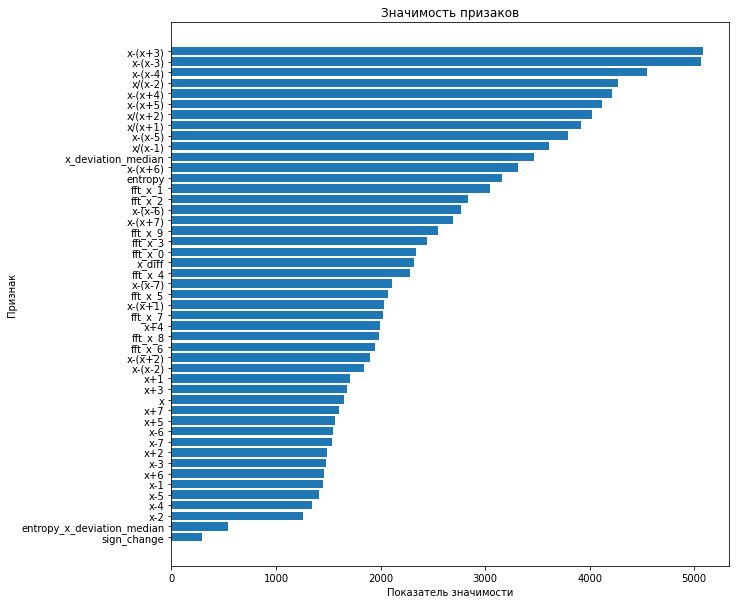

In [9]:
importance = model.feature_importances_
features = df.drop(['y','id','time'],axis=1).columns

sorted_indexes = np.argsort(importance)
fig = plt.figure(figsize=(10,10))
plt.barh(y=features[sorted_indexes], width=importance[sorted_indexes])
plt.title('Значимость призаков')
plt.xlabel('Показатель значимости')
plt.ylabel('Признак')
plt.show()

In [10]:
with open('model-isd-pipeline-10.pkl', 'wb') as f:
    pickle.dump(model, f)

# Проверка на тестовых данных

In [11]:
test_data = pd.read_csv('../input/cardiospikecompetition/test.csv')

In [12]:
test_df = make_dataset(test_data)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15034 entries, 0 to 15033
Data columns (total 49 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          15034 non-null  int64  
 1   time                        15034 non-null  int64  
 2   x                           15034 non-null  int64  
 3   fft_x_0                     15034 non-null  float64
 4   fft_x_1                     15034 non-null  float64
 5   fft_x_2                     15034 non-null  float64
 6   fft_x_3                     15034 non-null  float64
 7   fft_x_4                     15034 non-null  float64
 8   fft_x_5                     15034 non-null  float64
 9   fft_x_6                     15034 non-null  float64
 10  fft_x_7                     15034 non-null  float64
 11  fft_x_8                     15034 non-null  float64
 12  fft_x_9                     15034 non-null  float64
 13  entropy                     150

In [13]:
with open('scaler-isd-pipeline-10.pkl', 'rb') as f:
    scaler = pickle.load(f)
    
X_test = test_df.drop(['id','time'], axis=1).to_numpy()
X_test = scaler.transform(X_test)

print(X_test.shape)

(15034, 47)


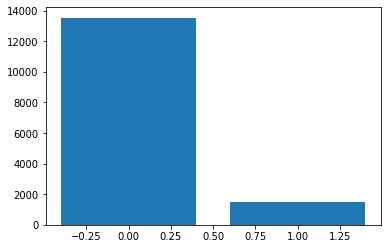

In [14]:
y_pred = model.predict(X_test)
plt.bar([0,1], [len(y_pred)-sum(y_pred), sum(y_pred)]);

In [15]:
# submit
submit = test_data.copy()
submit['y'] = y_pred
submit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15034 entries, 0 to 15033
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   id      15034 non-null  int64
 1   time    15034 non-null  int64
 2   x       15034 non-null  int64
 3   y       15034 non-null  int64
dtypes: int64(4)
memory usage: 469.9 KB


In [16]:
submit

,id,time,x,y
0,81,0,576,0
1,81,568,568,0
2,81,1140,572,0
3,81,1716,576,0
4,81,2284,568,0
...,...,...,...,...
15029,176,44332,568,1
15030,176,44968,636,1
15031,176,45596,628,0
15032,176,46904,1308,0


In [17]:
submit.to_csv('submit-isd-pipeline-10.csv', index=False)

# Дополнительное для презентации

In [18]:
print('0:', len(df)-sum(df.y))
print('1:', sum(df.y))

0: 47432
1: 8961


In [19]:
print('0:', 100*(len(df)-sum(df.y))/len(df), '%')
print('1:', 100*sum(df.y)/len(df), '%')

0: 84.10972993101981 %
1: 15.890270068980193 %


In [23]:
x_cols = df.drop(['id','time','y'],axis=1).columns
corr = df[x_cols].corrwith(df.y)


x                             0.012489
fft_x_0                       0.014907
fft_x_1                       0.006115
fft_x_2                       0.002840
fft_x_3                       0.000778
fft_x_4                      -0.000053
fft_x_5                      -0.000039
fft_x_6                       0.000193
fft_x_7                       0.000698
fft_x_8                       0.000769
fft_x_9                       0.000667
entropy                      -0.235143
x_diff                       -0.000870
x_deviation_median           -0.019429
sign_change                  -0.001503
x+1                           0.015041
x-1                           0.013826
x+2                           0.017743
x-2                           0.015331
x+3                           0.017498
x-3                           0.018359
x+4                           0.015830
x-4                           0.019996
x+5                           0.015799
x-5                           0.021487
x+6                      